In [103]:
import csv
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split as train_test_split
import numpy as np
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Activation, LSTM, Dropout
import tensorflow.keras.optimizers
from tensorflow.keras.callbacks import CSVLogger
import os
import datetime

In [104]:
CSV= pd.read_csv('ge.us.csv', delimiter=',')
CSV.tail()

,Date,Open,High,Low,Close,Volume,OpenInt
14053,2017-11-06,20.52,20.530,20.08,20.13,60641787,0
14054,2017-11-07,20.17,20.250,20.12,20.21,41622851,0
14055,2017-11-08,20.21,20.320,20.07,20.12,39672190,0
14056,2017-11-09,20.04,20.071,19.85,19.99,50831779,0
14057,2017-11-10,19.98,20.680,19.90,20.49,100698474,0


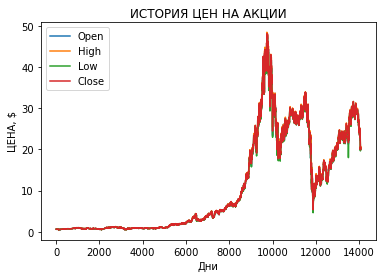

In [105]:

plt.plot(CSV["Open"])
plt.plot(CSV["High"])
plt.plot(CSV["Low"])
plt.plot(CSV["Close"])
plt.title('ИСТОРИЯ ЦЕН НА АКЦИИ')
plt.ylabel('ЦЕНА, $')
plt.xlabel('Дни')
plt.legend(['Open','High','Low','Close'], loc='upper left')
plt.show()



In [106]:
print("checking if any null values are present\n", CSV.isna().sum())

checking if any null values are present
 Date       0
Open       0
High       0
Low        0
Close      0
Volume     0
OpenInt    0
dtype: int64


In [107]:
from sklearn.model_selection import train_test_split as train_test_split
train_cols = ["Open","High","Low","Close","Volume"]
df_train, df_test = train_test_split(CSV, train_size=0.8, test_size=0.2, shuffle=False)
print("Тренировочные и тестовые значения", len(df_train), len(df_test))

x = df_train.loc[:,train_cols].values
min_max_scaler = MinMaxScaler()
x_train = min_max_scaler.fit_transform(x)
x_test = min_max_scaler.transform(df_test.loc[:,train_cols])

Тренировочные и тестовые значения 11246 2812


In [108]:
def build_timeseries(mat, y_col_index):
    TIME_STEPS = 60
    
    dim_0 = mat.shape[0] - TIME_STEPS
    dim_1 = mat.shape[1]
    x = np.zeros((dim_0, TIME_STEPS, dim_1))
    y = np.zeros((dim_0,))
    
    for i in range(dim_0):
        x[i] = mat[i:TIME_STEPS+i]
        y[i] = mat[TIME_STEPS+i, y_col_index]
    print("Продолжительность временного ряда i/o",x.shape,y.shape)
    return x, y

In [109]:

def trim_dataset(mat, batch_size):
    no_of_rows_drop = mat.shape[0]%batch_size
    if(no_of_rows_drop > 0):
        return mat[:-no_of_rows_drop]
    else:
        return mat

Продолжительность временного ряда i/o (11186, 60, 5) (11186,)
Продолжительность временного ряда i/o (2752, 60, 5) (2752,)
Epoch 1/15
159/159 - 39s - loss: 0.0034 - val_loss: 0.0636
Epoch 2/15
159/159 - 35s - loss: 0.0321 - val_loss: 0.0825
Epoch 3/15
159/159 - 36s - loss: 0.0101 - val_loss: 0.0881
Epoch 4/15
159/159 - 36s - loss: 0.2572 - val_loss: 0.0323
Epoch 5/15
159/159 - 36s - loss: 0.0080 - val_loss: 0.0700
Epoch 6/15
159/159 - 36s - loss: 0.0264 - val_loss: 0.0345
Epoch 7/15
159/159 - 36s - loss: 0.0263 - val_loss: 0.0258
Epoch 8/15
159/159 - 35s - loss: 0.0129 - val_loss: 0.0433
Epoch 9/15
159/159 - 36s - loss: 0.0070 - val_loss: 0.0121
Epoch 10/15
159/159 - 36s - loss: 0.0043 - val_loss: 0.0071
Epoch 11/15
159/159 - 36s - loss: 0.0048 - val_loss: 0.0075
Epoch 12/15
159/159 - 35s - loss: 0.0047 - val_loss: 0.0147
Epoch 13/15
159/159 - 35s - loss: 0.0055 - val_loss: 0.0077
Epoch 14/15
159/159 - 34s - loss: 0.0032 - val_loss: 0.0068
Epoch 15/15
159/159 - 34s - loss: 0.0024 - val_

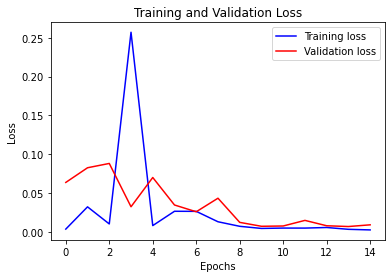

ValueError: x and y must have same first dimension, but have shapes (1,) and (11130, 60, 5)

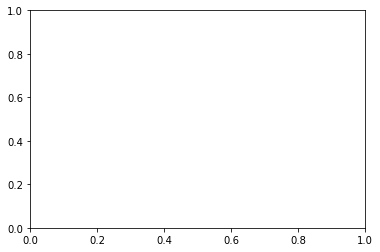

In [113]:
BATCH_SIZE = 70
TIME_STEPS = 60
OUTPUT_PATH = 15



x_t, y_t = build_timeseries(x_train, 3)
x_t = trim_dataset(x_t, BATCH_SIZE)
y_t = trim_dataset(y_t, BATCH_SIZE)
x_temp, y_temp = build_timeseries(x_test, 3)
x_val, x_test_t = np.split(trim_dataset(x_temp, BATCH_SIZE),2)
y_val, y_test_t = np.split(trim_dataset(y_temp, BATCH_SIZE),2)

from tensorflow.keras.optimizers import Adam

X_test = trim_dataset(x_val, BATCH_SIZE)
Y_test = trim_dataset(y_val, BATCH_SIZE)

lstm_model = Sequential()
lstm_model.add(LSTM(100, batch_input_shape=(BATH_SIZE, TIME_STEPS, x_t.shape[2]), dropout=0.0, recurrent_dropout=0.0, stateful=True,     kernel_initializer='random_uniform'))
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(20,activation='relu'))
lstm_model.add(Dense(1,activation='linear'))

lstm_model.compile(loss='MSE', optimizer=Adam(0.01))

csv_logger = CSVLogger(os.path.join('training.log'))

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
epochs = 15
history = lstm_model.fit(x_t, y_t, epochs=epochs, verbose=2, batch_size=BATCH_SIZE,
                    shuffle=False, validation_data=(X_test, Y_test), callbacks=[csv_logger])



def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_loss(history, "Training and Validation Loss")

def visualize_train(history, title):
    valid = history.history['valid_train']
    

ValueError: x and y must have same first dimension, but have shapes (1,) and (1330, 60, 5)

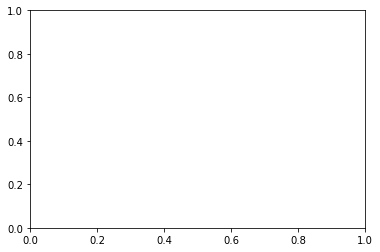

In [114]:
plt.plot(epochs, X_test, Y_test,'r')

plt.plot(x_val*len(epochs), y_val*len(epochs),'b')

plt.show()